In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from load_masks_from_json import load_masks_from_json
from folder_image_path import FolderImagePath

# Load Data

## Get image and json path from the folder

In [4]:
import os

def get_paths():
    # Get the image name from To_be_seg folder
    to_be_seg_path = r'To_be_seg'
    
    # List all files in the directory and filter out hidden files
    files = [f for f in os.listdir(to_be_seg_path) 
             if not f.startswith('.') and os.path.isfile(os.path.join(to_be_seg_path, f))]
    
    if not files:
        raise Exception("No valid image files found in To_be_seg folder")
    
    # Get the first file name and its name without extension
    image_filename = files[0]
    image_name = os.path.splitext(image_filename)[0]
    
    # Construct both paths
    image_path = os.path.join(to_be_seg_path, image_filename)
    json_path = os.path.join('Seg_Images', image_name, f'{image_name}.json')
    
    return image_path, json_path

# Usage
try:
    image_path, json_path = get_paths()
    print(f"Image path: {image_path}")
    print(f"JSON path: {json_path}")
except Exception as e:
    print(f"Error: {str(e)}")

Image path: To_be_seg\USU-4183B 150-250 Elemental Map_aligned.png
JSON path: Seg_Images\USU-4183B 150-250 Elemental Map_aligned\USU-4183B 150-250 Elemental Map_aligned.json


## Load the image and the masks from the json file

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Take some time to load the json file, be patient!

In [7]:
# json_path = r'Seg_Images\USU-4183B 150-250 Elemental Map\USU-4183B 150-250 Elemental Map.json'
masks = load_masks_from_json(json_path)

# Display grains with their mask indexes

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def display_label_on_image(image, masks, filter_list=None):
    idx_list = list(range(len(masks)))
    
    # If filter_list is provided, filter out the indices that are in the filter_list
    if filter_list is not None:
        idx_list = [idx for idx in idx_list if idx not in filter_list]

    # Create a figure for displaying the image with labels
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.axis('off')
    
    # Label each mask by its index
    for idx, segmentation_entry in enumerate(masks):
        if idx in idx_list:
            segmentation_mask = np.array(segmentation_entry['segmentation']).astype(np.uint8)
            if np.any(segmentation_mask):
                y, x = center_of_mass(segmentation_mask)
                ax.text(x, y, str(idx), color='red', fontsize=6, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

    plt.show()

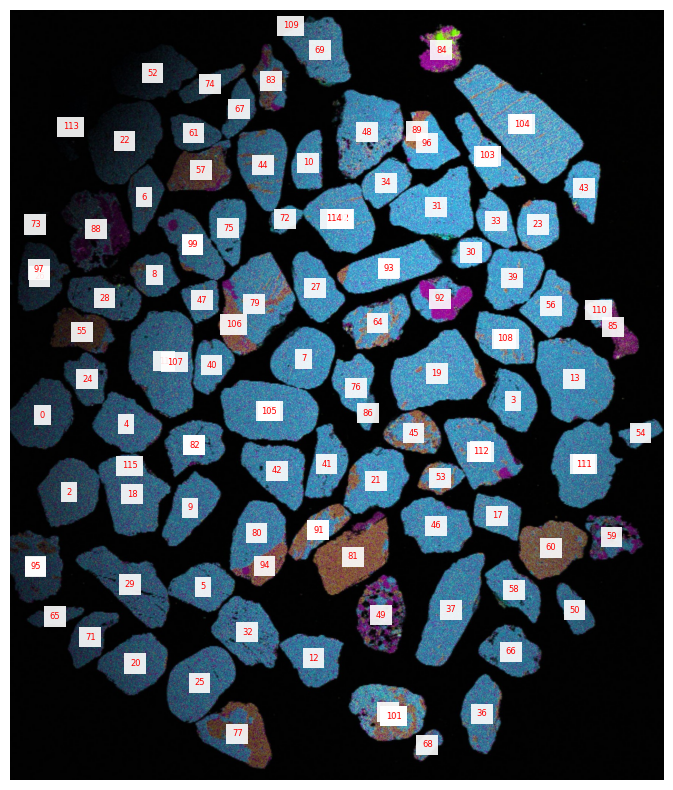

In [9]:
display_label_on_image(image, masks)

# Remove Replicate Labels or Labels with overlap

## Logic Cleaning

If there is replicate or overlapping, remove the one whose index is larger (lower confidence)

In [10]:
def check_overlap(mask1, mask2):
    # Create binary masks
    binary_mask1 = mask1['segmentation'].astype(bool)
    binary_mask2 = mask2['segmentation'].astype(bool)
    # Check if there is any overlap
    overlap = np.logical_and(binary_mask1, binary_mask2)
    return np.any(overlap)

def find_labels_to_remove(masks):
    labels_to_remove = set()
    num_masks = len(masks)

    for i in range(num_masks):
        if i in labels_to_remove:
            continue
        for j in range(i + 1, num_masks):
            if j in labels_to_remove:
                continue
            if check_overlap(masks[i], masks[j]):
                # Print the conflicting pair
                print(f"Conflict between mask {i} and mask {j}")

                # Keep the smaller label and remove the other
                if i < j:
                    labels_to_remove.add(j)
                else:
                    labels_to_remove.add(i)

    # Convert the set to a sorted list
    labels_to_remove = sorted(list(labels_to_remove))
    
    # Print the final list of labels to remove
    print(f"Labels to remove: {labels_to_remove}")
    
    return labels_to_remove


In [12]:
labels_to_remove = find_labels_to_remove(masks)

Conflict between mask 1 and mask 98
Conflict between mask 1 and mask 105
Conflict between mask 3 and mask 108
Conflict between mask 4 and mask 115
Conflict between mask 9 and mask 82
Conflict between mask 10 and mask 114
Conflict between mask 11 and mask 107
Conflict between mask 14 and mask 93
Conflict between mask 15 and mask 111
Conflict between mask 17 and mask 112
Conflict between mask 26 and mask 97
Conflict between mask 35 and mask 102
Conflict between mask 36 and mask 101
Conflict between mask 38 and mask 100
Conflict between mask 41 and mask 91
Conflict between mask 43 and mask 104
Conflict between mask 47 and mask 99
Conflict between mask 51 and mask 95
Conflict between mask 70 and mask 103
Conflict between mask 76 and mask 86
Conflict between mask 79 and mask 106
Conflict between mask 80 and mask 94
Conflict between mask 85 and mask 110
Conflict between mask 89 and mask 96
Labels to remove: [82, 86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108,

Next step, you're going to leverage this list generated by logic filtering, and then start to do manual cleaning


- **Copy `labels_to_remove` in the above printout, and then go to `4_1_Click_unwanted_indexes_printout_list.py` and paste into the `filter_list` there and then run that script.**
- **Remember to change the image and json path there as well**
- **The idea of this process is to use the logic filtered list as a starting point, and then manually check the rest of the masks to see if there are any other unwanted masks that need to be removed.**


In [ ]:
"""
    You can iterate the above step until a satisfying index list to be removed
"""

In [13]:
iterated_index_to_be_removed = [22, 26, 52, 73, 82, 86, 88, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115]

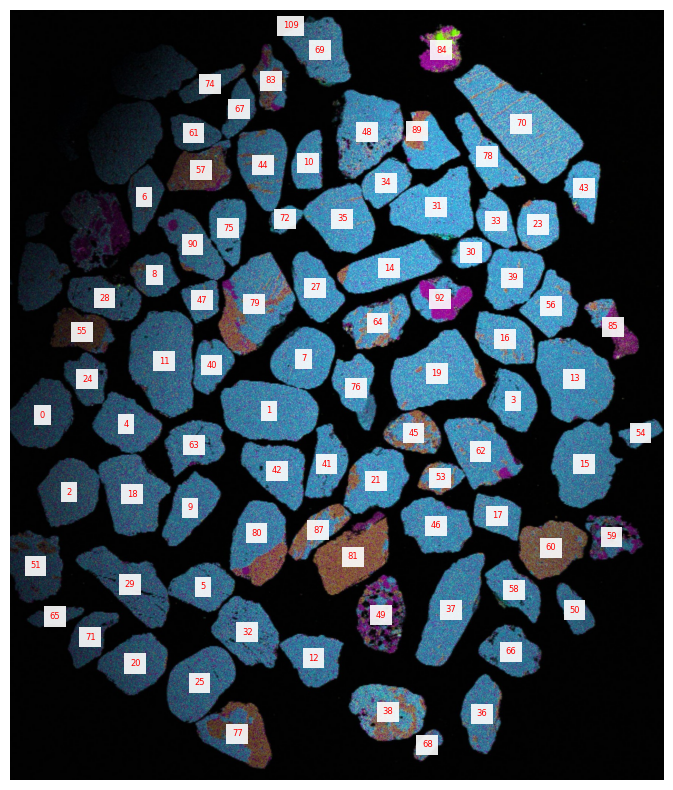

In [14]:
display_label_on_image(image, masks, filter_list=iterated_index_to_be_removed)

In [14]:
def display_binary_mask_and_overylay(image, masks, filter_list=None, image_2=None, overlay_color=(0, 255, 0), alpha=0.3):
    """
    Display 1) original image; 2) Binary mask; 3) original image with layered with the mask, mask's color is chosable

    Parameters:
    image (numpy array): The image to display.
    masks (list): The list of masks (dictionaries with 'segmentation' key).
    filter_list (list): List of indices to exclude from display (optional).
    image_2 (numpy array): The second image to overlay masks on (optional).
    overlay_color (tuple): The RGB color for the overlay (default is green).
    alpha (float): The transparency level of the overlay (default is 0.3).

    Returns:
    numpy array: The combined mask.
    """
    # Generate idx_list by enumerating each mask
    idx_list = list(range(len(masks)))

    # If filter_list is provided, filter out the indices that are in the filter_list
    if filter_list is not None:
        idx_list = [idx for idx in idx_list if idx not in filter_list]

    # Initialize a mask of zeros with the same size as the original image
    combined_mask = np.zeros_like(image[:,:,0], dtype=np.uint8)

    for idx, segmentation_entry in enumerate(masks):
        if idx in idx_list:  # Only consider masks in idx_list
            segmentation_mask = np.array(segmentation_entry['segmentation']).astype(np.uint8)
            # Combine the mask
            combined_mask = np.logical_or(combined_mask, segmentation_mask)

    # Convert combined_mask back to uint8 for visualization
    combined_mask = combined_mask.astype(np.uint8)

    # Create overlayed images
    overlayed_image = image.copy()
    
    if image_2 is not None:
        overlayed_image_2 = image_2.copy()
    
    # Create an overlay of the same size as the original image with the specified color
    color_overlay = np.zeros_like(image)
    color_overlay[combined_mask == 1] = overlay_color

    # Compute the alpha-blended images only in the regions specified by the mask
    overlayed_image[combined_mask == 1] = (color_overlay[combined_mask == 1] * alpha + 
                                           image[combined_mask == 1] * (1 - alpha)).astype(np.uint8)
    
    if image_2 is not None:
        overlayed_image_2[combined_mask == 1] = (color_overlay[combined_mask == 1] * alpha + 
                                                 image_2[combined_mask == 1] * (1 - alpha)).astype(np.uint8)

    plt.figure(figsize=(30,20))

    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Display the combined mask
    plt.subplot(2, 3, 2)
    plt.imshow(combined_mask, cmap='gray')
    plt.title('Combined Mask')
    plt.axis('off')

    # Display the overlayed images
    plt.subplot(2, 3, 3)
    plt.imshow(overlayed_image)
    plt.title('Overlayed on Original Image')
    plt.axis('off')

    if image_2 is not None:
        plt.subplot(2, 3, 4)
        plt.imshow(overlayed_image_2)
        plt.title('Overlayed on Image 2')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    return combined_mask

In [15]:
# image_K = cv2.imread(image_paths[1])
# image_K = cv2.cvtColor(image_K, cv2.COLOR_BGR2RGB)
# combined_mask = display_binary_mask_and_overylay(image_K, masks, filter_list=None, overlay_color=(253, 36, 255))
combined_mask = display_binary_mask_and_overylay(image, masks, filter_list=iterated_index_to_be_removed, overlay_color=(253, 36, 255))


In [ ]:
'''
    Here goes to run `Click_Image_Return_Index.py`
    Copy and paste index list you decided to remove.
    Therefore in the next python file you are going to run, these indexes won't distract your click to return the index
'''
'''
    Don't save another json file after data cleaning, just save the indexes list. Filter it or combine
    it when you need. Save another json file, when you import it. The idx of the new file won't match with
    the original file for the same mask.
'''